In [1]:
from collections import OrderedDict

import pandas as pd
import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F

import torch.distributions.multivariate_normal as mn
import math

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Dataset

In [2]:
def wflist(filename):
    wflist = []
    f = h5py.File(filename,'r')
    tp0 = np.array(f["raw"]["tp_0"])
    wf = np.array(f["raw"]["waveform"]["values"])
    tdrift = np.array(f["raw"]["dt"])
    avse = np.array(f["raw"]["A"]["E"])
    index = np.array(f["raw"]["index"])

    for i in range(len(tp0)):
        if np.isnan(tp0[i]):
            continue
        wflist.append({"wf":wf[i],
                       "t0":int(tp0[i]/16.0),
                       "tDrift":tdrift[i],
                       "avse": avse[i],
                       "index": index[i],
                    })
    return wflist

In [3]:
def wf_dataframe(wflist):
    wf = []
    t0 = []
    tDrift = []
    avse = []
    index = []
    for i in range(len(wflist)):
        wf.append(wflist[i]['wf'])
        t0.append(wflist[i]['t0'])
        tDrift.append(wflist[i]['tDrift'])
        avse.append(wflist[i]['avse'])
        index.append(wflist[i]['index'])

    wf = np.array(wf)
    t0 = np.array(t0)
    tDrift = np.array(tDrift)
    avse = np.array(avse)
    index = np.array(index)
    
    
    data = pd.DataFrame()
#     for i in range(wf.shape[1]):
#         tmp = []
#         for j in range(wf.shape[0]):
#             tmp.append(wf[j][i])
#         data['wf' + str(i)] = tmp

    A = ['wf'+str(i) for i in range (3748)]
    data = pd.DataFrame(wf, columns = A)
    data['t0'] = t0
    data['tDrift'] = tDrift
    data['avse'] = avse

    return data

In [4]:
filename_dep = '/Users/zaret/Desktop/gerda/w2022/ICPC/V05612B.lh5'
filename_fep = '/Users/zaret/Desktop/gerda/w2022/ICPC/V05612B_fep.lh5'

In [5]:
wflist_dep = wflist(filename_dep)
dep = wf_dataframe(wflist_dep)
dep['label'] = 1

In [6]:
wflist_fep = wflist(filename_fep)
fep = wf_dataframe(wflist_fep)
fep['label'] = 1

In [7]:
# wflist_fep = wflist(filename_fep)
# fep = wf_dataframe(wflist_fep)
# fep['label'] = 0

# fep = fep[fep['avse'] > 0.880]
# fep = fep[fep['avse'] < 0.910]
# # fep = fep.iloc[:148,:]

In [8]:
# data = pd.concat([dep, fep])
data = dep

In [9]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse,label
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110,1
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085,1
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621,1
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228,1
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792,1
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742,1
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692,1
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924,1


In [10]:
data.drop('avse', inplace = True, axis = 1)
data.drop('tDrift', inplace = True, axis = 1)
data.drop('t0', inplace = True, axis = 1)

In [11]:
# data = data.iloc[:-19750,:]

In [12]:
data = data.reset_index()
data.drop(data.columns[[0]], axis  = 1, inplace = True)

In [13]:
#sns.countplot(x = 'label', data = data)

In [14]:
targets = np.array(data['label'])
data2 = np.array(data.iloc[:, :-1])


arr1 = np.array(data2)
arr1 = arr1.astype('float')
arr = arr1

for i in range(arr1.shape[0]):
    arr[i] = (arr1[i] - arr1[i].min())
    arr[i] = arr[i] / arr[i].max()
    
data1 = arr


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data1 = scaler.fit_transform(data1) 

In [16]:
train_data = torch.tensor(data1, dtype=torch.float)
train_labels = torch.tensor(targets, dtype=torch.int)

train_set = [
    (train_data[i], train_labels[i]) for i in range(targets.shape[0])
]

In [17]:
batch_size = 128

data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [18]:
def plot_quantity(dataloader):
    Targets = []
    for i,(example_data, example_targets) in enumerate(dataloader):
        example_targets = list(example_targets.numpy())
        for i in example_targets:
            Targets.append(i)
    
    d = dict()
    for i in Targets:
        if i not in d:
            d[i] = 1
        else:
            d[i] += 1
       
    d = OrderedDict(sorted(d.items()))
    
    sns.countplot(x = Targets )
    for i, j in d.items():
        print(i, j, sep = ' : ', end = '; ')

1 : 19840; 

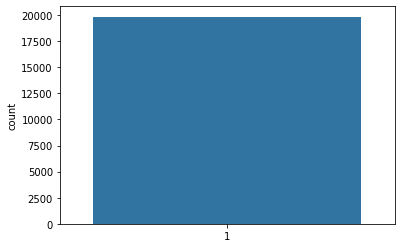

In [19]:
plot_quantity(data_loader)

In [20]:
train_data.shape

torch.Size([19916, 3748])

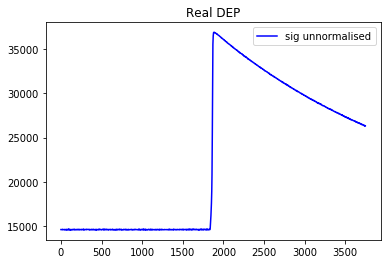

In [21]:
plt.plot(np.array(data.iloc[0,:-1]), color = 'blue', label = 'sig unnormalised')
plt.title('Real DEP')
plt.legend()

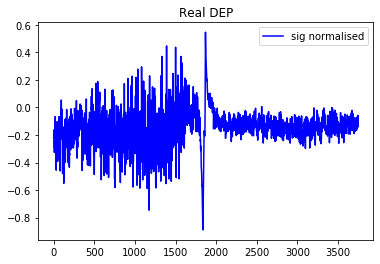

In [22]:
plt.plot(data1[0], color = 'blue', label = 'sig normalised')
plt.title('Real DEP')
plt.legend()

## Models

In [23]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 3748
emb_dim = seq_len // 16
#wgan
hidden_dim = 8
latent_dims = 32 


In [24]:
train_dir = 'training'
checkpoint_dir = 'checkpoint'
distribution_dir = 'distribution'

In [25]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dims
        self.no_features = 1
        
        self.LSTM1 = nn.GRU(
            input_size = self.latent_dim,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )
        
        #self.fc1 = nn.Linear(self.hidden_dims * 4, self.hidden_dims)
        self.fc2 = nn.Linear(self.hidden_dim, self.no_features)


    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.emb_dim, 1)
        x, h0 = self.LSTM1(x)
        x = x.reshape((-1, self.emb_dim, self.hidden_dim))
        #x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [48]:
class Encoder(nn.Module):   ## changed
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 8, self.emb_dim, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [49]:
G = Generator()
D = Decoder()
E = Encoder()

In [30]:
D.load_state_dict(torch.load("decoder.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [51]:
E.load_state_dict(torch.load("encoder.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
G.load_state_dict(torch.load("generator.pth", map_location=torch.device('cpu')))


#G.load_state_dict(torch.load("wgan_gru_500.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
########

In [55]:
tmp = torch.randn(5, latent_dims)

In [56]:
g = G(tmp).detach()

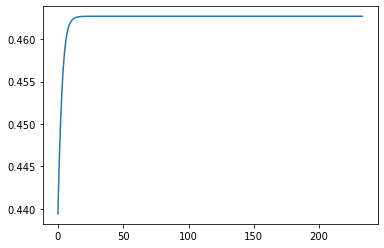

In [57]:
plt.plot(g[0])

In [58]:
decoded = D(g).detach()

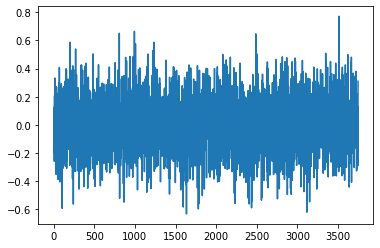

In [59]:
plt.plot(decoded[0])

In [60]:
fin = scaler.inverse_transform(decoded.cpu().data.numpy())

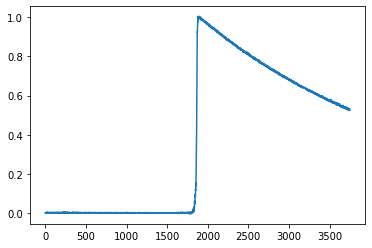

In [61]:
plt.plot(fin[0])

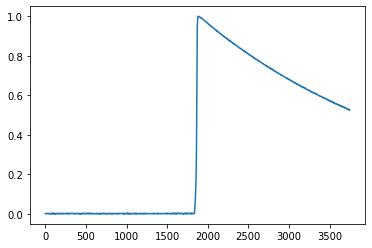

In [46]:
plt.plot(arr[0])

In [ ]:
##############

In [168]:
A = torch.randn(10000, latent_dims)

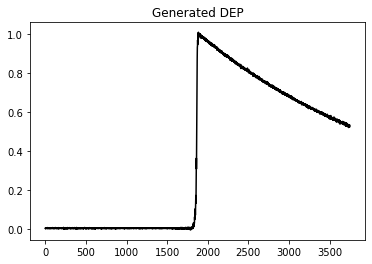

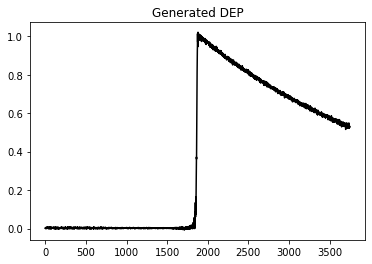

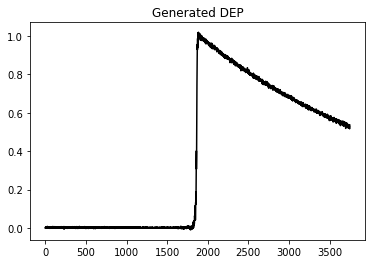

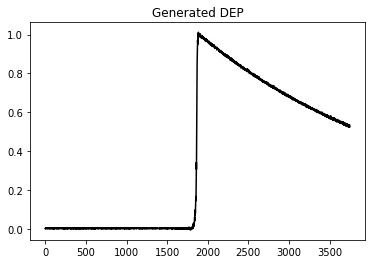

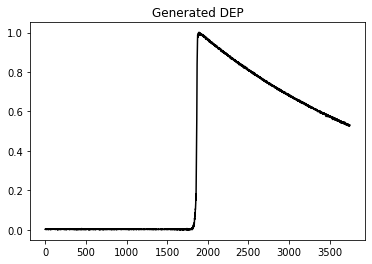

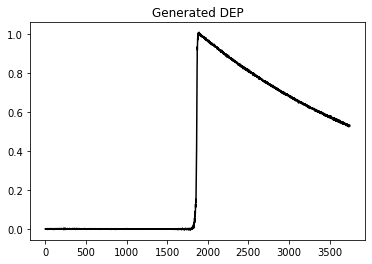

In [169]:
gen = D(G(A).detach()).detach()
gen = scaler.inverse_transform(gen.cpu().data.numpy()) 
#gen = gen * 36835
for i in range(6):
# inverse scaling !!!
    plt.plot(gen[i], color = 'black')
    plt.title('Generated DEP')
    plt.show()

In [170]:
generated_samples = D(G(A).detach()).detach()# DEP events generation 
generated_samples = scaler.inverse_transform(generated_samples.cpu().data.numpy())
gen = generated_samples

In [ ]:
###############
# normalisation 

In [119]:
# tmp = gen

In [122]:
# for i in range(tmp.shape[0]):
#     tmp[i] = (tmp[i] - tmp[i].min()) / tmp[i].max()

In [125]:
# gen = tmp

In [ ]:
############

In [171]:
gen = pd.DataFrame()
for i in range(generated_samples.shape[1]):
    tmp = []
    for j in range(generated_samples.shape[0]):
        tmp.append(generated_samples[j][i])
    gen['wf' + str(i)] = tmp

In [172]:
############

In [173]:
# B = torch.randn(10000, latent_dims)

In [174]:
# generated_samples1 = D(G(B).detach()).detach()# DEP events generation 
# generated_samples1 = scaler.inverse_transform(generated_samples1.cpu().data.numpy())
# gen1 = generated_samples1

In [175]:
# gen1 = pd.DataFrame()
# for i in range(generated_samples1.shape[1]):
#     tmp = []
#     for j in range(generated_samples1.shape[0]):
#         tmp.append(generated_samples1[j][i])
#     gen1['wf' + str(i)] = tmp

In [176]:
#######

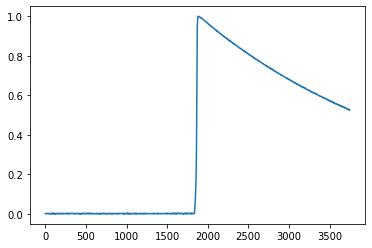

In [177]:
plt.plot(arr[0])

In [178]:
DEP = pd.DataFrame()
for i in range(arr.shape[1]):
    tmp = []
    for j in range(arr.shape[0]):
        tmp.append(arr[j][i])
    DEP['wf' + str(i)] = tmp

In [179]:
DEP

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001699,0.001699,0.001699,0.002013,0.002013,0.001699,0.001565,0.001342,0.001386,0.001118,...,0.527191,0.526923,0.527057,0.527281,0.527818,0.526297,0.526431,0.526834,0.527057,0.526521
1,0.003008,0.003008,0.002559,0.002200,0.001931,0.002110,0.001975,0.001841,0.001706,0.002200,...,0.528913,0.529766,0.529721,0.529272,0.529227,0.529182,0.528329,0.527611,0.527521,0.527252
2,0.001165,0.001165,0.001255,0.001255,0.001210,0.001165,0.001883,0.002689,0.002734,0.002376,...,0.528441,0.528800,0.528486,0.528128,0.527545,0.527455,0.527500,0.527142,0.527142,0.527455
3,0.000806,0.000806,0.001120,0.001299,0.001792,0.001120,0.000403,0.000672,0.001299,0.001702,...,0.528603,0.528110,0.527841,0.527393,0.527752,0.527796,0.527528,0.527214,0.527841,0.527707
4,0.001793,0.001793,0.002511,0.002690,0.002735,0.002825,0.002870,0.002780,0.002332,0.002914,...,0.530691,0.530198,0.530287,0.530601,0.530287,0.530691,0.530870,0.530153,0.529705,0.529436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,0.003366,0.003366,0.002872,0.002378,0.002693,0.003321,0.003455,0.003141,0.002513,0.002872,...,0.529259,0.528630,0.527823,0.527553,0.527105,0.526835,0.527419,0.526835,0.526656,0.526476
19912,0.001839,0.001839,0.002198,0.002422,0.002467,0.002467,0.003050,0.003453,0.003095,0.002646,...,0.529264,0.529443,0.528726,0.528008,0.527829,0.527829,0.527784,0.527425,0.526618,0.525855
19913,0.001747,0.001747,0.002015,0.001702,0.001702,0.002508,0.002374,0.001523,0.001254,0.000941,...,0.527836,0.527299,0.527388,0.527657,0.527747,0.527209,0.526851,0.526537,0.526134,0.526269
19914,0.001030,0.001030,0.000985,0.001209,0.001747,0.002732,0.002911,0.002463,0.001926,0.001702,...,0.528798,0.527544,0.527857,0.528529,0.528977,0.529111,0.528708,0.528260,0.527723,0.527186


In [180]:
gen

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001840,0.000420,0.003514,0.003567,0.001875,0.001196,0.004245,0.001272,0.000264,0.004822,...,0.530449,0.527914,0.533057,0.530117,0.526357,0.530226,0.532847,0.526231,0.522868,0.532411
1,0.001280,0.002592,0.004662,0.000496,0.001910,0.004966,0.004895,0.001012,-0.000262,-0.001087,...,0.537246,0.531806,0.521803,0.527902,0.535144,0.530770,0.530645,0.524121,0.532743,0.529458
2,-0.000593,-0.001397,0.004480,0.003787,0.001621,0.000725,0.005829,-0.000209,-0.001349,0.005240,...,0.526372,0.533363,0.531260,0.530234,0.525307,0.530669,0.533218,0.520252,0.516572,0.537201
3,0.001713,0.000859,0.003387,0.004694,0.002159,0.001001,0.004443,0.000928,0.000594,0.003340,...,0.529180,0.527329,0.532387,0.534157,0.528611,0.529016,0.530780,0.526283,0.522485,0.533720
4,0.001978,0.001597,0.003272,0.002526,0.004401,0.001929,0.002484,0.002577,0.003003,0.002690,...,0.529805,0.527904,0.525712,0.526360,0.527868,0.525549,0.530990,0.525939,0.530622,0.532105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000132,0.001513,0.003012,0.001808,0.003278,0.001298,0.002626,0.002057,0.002178,0.001797,...,0.534224,0.529582,0.527742,0.527216,0.529550,0.526649,0.530998,0.525916,0.536608,0.536450
9996,0.002871,0.002288,0.001709,0.002781,0.003555,0.003842,0.002866,0.002645,0.002543,0.001849,...,0.529179,0.527430,0.530237,0.531388,0.532411,0.528443,0.530329,0.525813,0.525975,0.533329
9997,0.001737,0.000031,0.003641,0.004469,0.001671,0.000534,0.004895,0.000559,0.000090,0.003862,...,0.528196,0.528604,0.532488,0.534120,0.527420,0.529024,0.531204,0.525126,0.520863,0.533840
9998,0.001507,0.000872,0.003617,0.003697,0.001853,0.001465,0.003925,0.001570,0.000505,0.004689,...,0.529631,0.527801,0.531704,0.529594,0.526233,0.530338,0.532564,0.525866,0.522641,0.532824


In [181]:
max_real = []
for i in range(DEP.shape[0]):
    tmp = np.array(DEP.iloc[i,:-1])
    max_real.append(tmp.max())

In [182]:
max_gen = []
for i in range(gen.shape[0]):
    tmp = np.array(gen.iloc[i,:])
    max_gen.append(tmp.max())

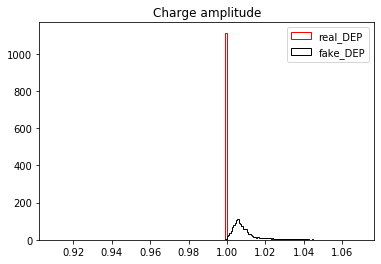

In [183]:
a1, _, _ = plt.hist(max_real, bins = 100, density = True, label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_gen, bins = 100, density = True, label = 'fake_DEP',histtype = 'step', color = 'black')
#a3, _, _ = plt.hist(max_realf, bins = 100, range = [35000, 40000], density = True, label = 'real_FEP',histtype = 'step', color = 'blue')
plt.legend()
plt.title('Charge amplitude')
plt.show()

#print("number of samples(real)", a1.sum())
# print("number of samples(gen)", a2.sum())
# print('\n')
# print('REAL amplitude:')
# print('min: ', np.array(max_real).min())
# print('max: ', np.array(max_real).max())
# print('avg: ', np.average(np.array(max_real)))
# print('\n')
# print('GEN amplitude:')
# print('min: ', np.array(max_gen).min())
# print('max: ', np.array(max_gen).max())
# print('avg: ', np.average(np.array(max_gen)))

In [184]:
dep_c = np.array(DEP.iloc[:,:])


curr_dep = []
for i in range(dep_c.shape[0]):
    tmp = []
    for j in range(dep_c.shape[1]-1):
        tmp.append(dep_c[i][j+1] - dep_c[i][j])
    curr_dep.append(tmp)
    
curr_dep = np.array(curr_dep)  
    
max_dep_c = []
for i in range(curr_dep.shape[0]):
    tmp = np.array(curr_dep[i])
    max_dep_c.append(tmp.max())

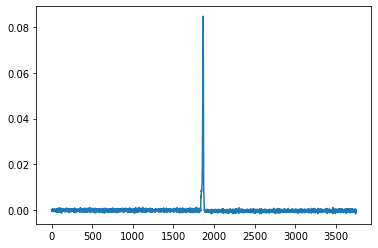

In [185]:
plt.plot(curr_dep[0])

In [186]:
gen_c = np.array(gen.iloc[:,:])

curr_gen = []
for i in range(gen_c.shape[0]):
    tmp = []
    for j in range(gen_c.shape[1]-1):
        tmp.append(gen_c[i][j+1] - gen_c[i][j])
    curr_gen.append(tmp)
    
curr_gen = np.array(curr_gen)

max_gen_c = []
for i in range(curr_gen.shape[0]):
    tmp = np.array(curr_gen[i])
    max_gen_c.append(tmp.max())

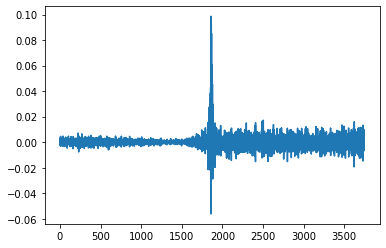

In [187]:
plt.plot(curr_gen[0])

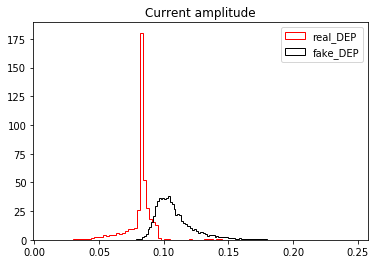

In [188]:
a1, _, _ = plt.hist(max_dep_c, bins = 100, label = 'real_DEP', density = True,histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_gen_c, bins = 100,  density = True, label = 'fake_DEP',histtype = 'step', color = 'black')
#a3, _, _ = plt.hist(max_dep_c, bins = 100, range = [np.array(max_real_c).min(), np.array(max_real_c).max()], density = True, label = 'real_DEP',histtype = 'step', color = 'blue')
plt.legend()
plt.title('Current amplitude')
plt.show()

In [189]:
#######################################
#SLOPE

In [190]:
DEP

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001699,0.001699,0.001699,0.002013,0.002013,0.001699,0.001565,0.001342,0.001386,0.001118,...,0.527191,0.526923,0.527057,0.527281,0.527818,0.526297,0.526431,0.526834,0.527057,0.526521
1,0.003008,0.003008,0.002559,0.002200,0.001931,0.002110,0.001975,0.001841,0.001706,0.002200,...,0.528913,0.529766,0.529721,0.529272,0.529227,0.529182,0.528329,0.527611,0.527521,0.527252
2,0.001165,0.001165,0.001255,0.001255,0.001210,0.001165,0.001883,0.002689,0.002734,0.002376,...,0.528441,0.528800,0.528486,0.528128,0.527545,0.527455,0.527500,0.527142,0.527142,0.527455
3,0.000806,0.000806,0.001120,0.001299,0.001792,0.001120,0.000403,0.000672,0.001299,0.001702,...,0.528603,0.528110,0.527841,0.527393,0.527752,0.527796,0.527528,0.527214,0.527841,0.527707
4,0.001793,0.001793,0.002511,0.002690,0.002735,0.002825,0.002870,0.002780,0.002332,0.002914,...,0.530691,0.530198,0.530287,0.530601,0.530287,0.530691,0.530870,0.530153,0.529705,0.529436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,0.003366,0.003366,0.002872,0.002378,0.002693,0.003321,0.003455,0.003141,0.002513,0.002872,...,0.529259,0.528630,0.527823,0.527553,0.527105,0.526835,0.527419,0.526835,0.526656,0.526476
19912,0.001839,0.001839,0.002198,0.002422,0.002467,0.002467,0.003050,0.003453,0.003095,0.002646,...,0.529264,0.529443,0.528726,0.528008,0.527829,0.527829,0.527784,0.527425,0.526618,0.525855
19913,0.001747,0.001747,0.002015,0.001702,0.001702,0.002508,0.002374,0.001523,0.001254,0.000941,...,0.527836,0.527299,0.527388,0.527657,0.527747,0.527209,0.526851,0.526537,0.526134,0.526269
19914,0.001030,0.001030,0.000985,0.001209,0.001747,0.002732,0.002911,0.002463,0.001926,0.001702,...,0.528798,0.527544,0.527857,0.528529,0.528977,0.529111,0.528708,0.528260,0.527723,0.527186


In [191]:
gen

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001840,0.000420,0.003514,0.003567,0.001875,0.001196,0.004245,0.001272,0.000264,0.004822,...,0.530449,0.527914,0.533057,0.530117,0.526357,0.530226,0.532847,0.526231,0.522868,0.532411
1,0.001280,0.002592,0.004662,0.000496,0.001910,0.004966,0.004895,0.001012,-0.000262,-0.001087,...,0.537246,0.531806,0.521803,0.527902,0.535144,0.530770,0.530645,0.524121,0.532743,0.529458
2,-0.000593,-0.001397,0.004480,0.003787,0.001621,0.000725,0.005829,-0.000209,-0.001349,0.005240,...,0.526372,0.533363,0.531260,0.530234,0.525307,0.530669,0.533218,0.520252,0.516572,0.537201
3,0.001713,0.000859,0.003387,0.004694,0.002159,0.001001,0.004443,0.000928,0.000594,0.003340,...,0.529180,0.527329,0.532387,0.534157,0.528611,0.529016,0.530780,0.526283,0.522485,0.533720
4,0.001978,0.001597,0.003272,0.002526,0.004401,0.001929,0.002484,0.002577,0.003003,0.002690,...,0.529805,0.527904,0.525712,0.526360,0.527868,0.525549,0.530990,0.525939,0.530622,0.532105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000132,0.001513,0.003012,0.001808,0.003278,0.001298,0.002626,0.002057,0.002178,0.001797,...,0.534224,0.529582,0.527742,0.527216,0.529550,0.526649,0.530998,0.525916,0.536608,0.536450
9996,0.002871,0.002288,0.001709,0.002781,0.003555,0.003842,0.002866,0.002645,0.002543,0.001849,...,0.529179,0.527430,0.530237,0.531388,0.532411,0.528443,0.530329,0.525813,0.525975,0.533329
9997,0.001737,0.000031,0.003641,0.004469,0.001671,0.000534,0.004895,0.000559,0.000090,0.003862,...,0.528196,0.528604,0.532488,0.534120,0.527420,0.529024,0.531204,0.525126,0.520863,0.533840
9998,0.001507,0.000872,0.003617,0.003697,0.001853,0.001465,0.003925,0.001570,0.000505,0.004689,...,0.529631,0.527801,0.531704,0.529594,0.526233,0.530338,0.532564,0.525866,0.522641,0.532824


In [192]:
d = np.array(DEP)

In [193]:
g = np.array(gen)

In [194]:
for i in range(d.shape[1]):
    if abs(d[0][i] - 0.97) <= 0.005:
        break

In [195]:
i

1873

In [196]:
d[0][1873]

0.9656082289803221

In [197]:
for i in range(d.shape[1]):
    if d[0][i]==1:
        break

In [198]:
i

1888

In [199]:
#1873 + ... + 1888

In [200]:
def slope(mas):
    p97 = []
    for i in range(mas.shape[0]):
        for j in range(1870, 1888):
            if abs(mas[i][j] - 0.97) <= 0.1:
                p97.append(j)
                break
            else:
                p97.append(1873)
                break
    p97 = np.array(p97) # shape==i
    
    avs = []
    for i in range(mas.shape[0]):
        sum1 = 0
        for j in range(p97[i] + 200,p97[i] + 300):
            sum1 = sum1 + mas[i][j]
        avs.append(sum1 / 100)        
    avs = np.array(avs)
    
    avs2 = []
    for i in range(mas.shape[0]):
        sum2 = 0
        for j in range(mas.shape[1] - 100, mas.shape[1]):
            sum2 = sum2 + mas[i][j]
        avs2.append(sum2 / 100)
    avs2 = np.array(avs2)
    
    
    slop = []
    for i in range(mas.shape[0]):
        distance = (mas.shape[1] - 50) - (p97[i] + 250)
        tmp = abs(avs2[i] - avs[i]) / distance
        slop.append(tmp)
    return np.array(slop)

In [201]:
sl_d = slope(d)
sl_g = slope(g)

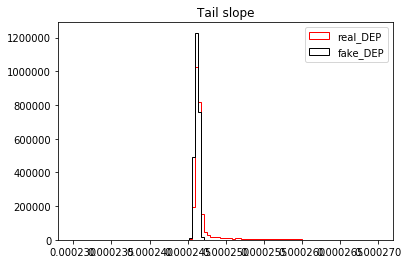

In [202]:
a1, _, _ = plt.hist(sl_d, bins = 100, density = True,range = [0.00023, 0.00027], label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(sl_g, bins = 100, density = True,range = [0.00023, 0.00027], label = 'fake_DEP',histtype = 'step', color = 'black')
#a3, _, _ = plt.hist(max_realf, bins = 100, range = [35000, 40000], density = True, label = 'real_FEP',histtype = 'step', color = 'blue')
plt.legend()
plt.title('Tail slope')
plt.show()

In [203]:
# drift time

In [204]:
DEP

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001699,0.001699,0.001699,0.002013,0.002013,0.001699,0.001565,0.001342,0.001386,0.001118,...,0.527191,0.526923,0.527057,0.527281,0.527818,0.526297,0.526431,0.526834,0.527057,0.526521
1,0.003008,0.003008,0.002559,0.002200,0.001931,0.002110,0.001975,0.001841,0.001706,0.002200,...,0.528913,0.529766,0.529721,0.529272,0.529227,0.529182,0.528329,0.527611,0.527521,0.527252
2,0.001165,0.001165,0.001255,0.001255,0.001210,0.001165,0.001883,0.002689,0.002734,0.002376,...,0.528441,0.528800,0.528486,0.528128,0.527545,0.527455,0.527500,0.527142,0.527142,0.527455
3,0.000806,0.000806,0.001120,0.001299,0.001792,0.001120,0.000403,0.000672,0.001299,0.001702,...,0.528603,0.528110,0.527841,0.527393,0.527752,0.527796,0.527528,0.527214,0.527841,0.527707
4,0.001793,0.001793,0.002511,0.002690,0.002735,0.002825,0.002870,0.002780,0.002332,0.002914,...,0.530691,0.530198,0.530287,0.530601,0.530287,0.530691,0.530870,0.530153,0.529705,0.529436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,0.003366,0.003366,0.002872,0.002378,0.002693,0.003321,0.003455,0.003141,0.002513,0.002872,...,0.529259,0.528630,0.527823,0.527553,0.527105,0.526835,0.527419,0.526835,0.526656,0.526476
19912,0.001839,0.001839,0.002198,0.002422,0.002467,0.002467,0.003050,0.003453,0.003095,0.002646,...,0.529264,0.529443,0.528726,0.528008,0.527829,0.527829,0.527784,0.527425,0.526618,0.525855
19913,0.001747,0.001747,0.002015,0.001702,0.001702,0.002508,0.002374,0.001523,0.001254,0.000941,...,0.527836,0.527299,0.527388,0.527657,0.527747,0.527209,0.526851,0.526537,0.526134,0.526269
19914,0.001030,0.001030,0.000985,0.001209,0.001747,0.002732,0.002911,0.002463,0.001926,0.001702,...,0.528798,0.527544,0.527857,0.528529,0.528977,0.529111,0.528708,0.528260,0.527723,0.527186


In [205]:
gen

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,0.001840,0.000420,0.003514,0.003567,0.001875,0.001196,0.004245,0.001272,0.000264,0.004822,...,0.530449,0.527914,0.533057,0.530117,0.526357,0.530226,0.532847,0.526231,0.522868,0.532411
1,0.001280,0.002592,0.004662,0.000496,0.001910,0.004966,0.004895,0.001012,-0.000262,-0.001087,...,0.537246,0.531806,0.521803,0.527902,0.535144,0.530770,0.530645,0.524121,0.532743,0.529458
2,-0.000593,-0.001397,0.004480,0.003787,0.001621,0.000725,0.005829,-0.000209,-0.001349,0.005240,...,0.526372,0.533363,0.531260,0.530234,0.525307,0.530669,0.533218,0.520252,0.516572,0.537201
3,0.001713,0.000859,0.003387,0.004694,0.002159,0.001001,0.004443,0.000928,0.000594,0.003340,...,0.529180,0.527329,0.532387,0.534157,0.528611,0.529016,0.530780,0.526283,0.522485,0.533720
4,0.001978,0.001597,0.003272,0.002526,0.004401,0.001929,0.002484,0.002577,0.003003,0.002690,...,0.529805,0.527904,0.525712,0.526360,0.527868,0.525549,0.530990,0.525939,0.530622,0.532105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000132,0.001513,0.003012,0.001808,0.003278,0.001298,0.002626,0.002057,0.002178,0.001797,...,0.534224,0.529582,0.527742,0.527216,0.529550,0.526649,0.530998,0.525916,0.536608,0.536450
9996,0.002871,0.002288,0.001709,0.002781,0.003555,0.003842,0.002866,0.002645,0.002543,0.001849,...,0.529179,0.527430,0.530237,0.531388,0.532411,0.528443,0.530329,0.525813,0.525975,0.533329
9997,0.001737,0.000031,0.003641,0.004469,0.001671,0.000534,0.004895,0.000559,0.000090,0.003862,...,0.528196,0.528604,0.532488,0.534120,0.527420,0.529024,0.531204,0.525126,0.520863,0.533840
9998,0.001507,0.000872,0.003617,0.003697,0.001853,0.001465,0.003925,0.001570,0.000505,0.004689,...,0.529631,0.527801,0.531704,0.529594,0.526233,0.530338,0.532564,0.525866,0.522641,0.532824


In [206]:
d1 = np.array(DEP)

In [207]:
g1 = np.array(gen)

In [208]:
tmp = d1[0]

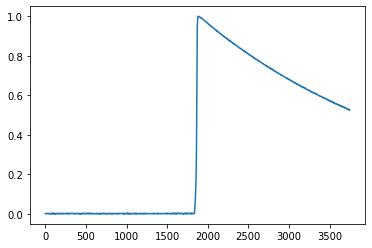

In [209]:
plt.plot(tmp)

In [210]:
def risetime(mas):
    risetimes = []
    for j in range(mas.shape[0]):
        for i in range(2000):
            if mas[j][i] - 0.9 <= 0.1:
                k90 = i
            if mas[j][i] - 0.1 <= 0.05:
                k10 = i
        risetimes.append(k90 - k10)
    risetimes = np.array(risetimes)
    return risetimes

In [211]:
rd = risetime(d1)

In [212]:
rg = risetime(g1)

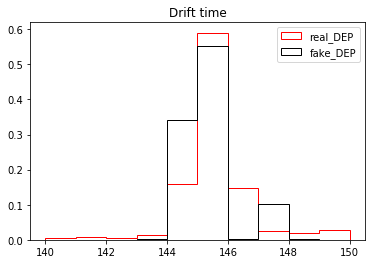

In [213]:
a1, _, _ = plt.hist(rd, bins = 10, density = True, range = [140, 150], label = 'real_DEP',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(rg, bins = 10, density = True,range = [140, 150], label = 'fake_DEP',histtype = 'step', color = 'black')
plt.legend()
plt.title('Drift time')
plt.show()